# INF 674 S6: Distances and Clustering

## Céline Comte & Fabien Mathieu

### 2016-2017

During the previous practical, you learned how to study the degree distribution on simple and oriented graphs, using the DBLP and Wikipedia datasets. The goal of this practical is to learn more refine techniques on the DBLP dataset.

In [1]:
%pylab inline
import networkx as nx

Populating the interactive namespace from numpy and matplotlib


# 1. Basic Tools

We provide you with a few functions to deal with the DBLP dataset (or other datasets with the same format). You will have to use them in the practical.

## File format

We remind the format of the provided datasets:
- **_dataset_.ids** contains the actual names of the nodes (one per line, $ n $ lines in total). By convention, each node is associated to its line number (from $ 0 $ to $ n-1 $). Actual names may contain special characters (e.g. *ç*, *é*), so it is encoded with *utf-8*.
- **_dataset_.adja** contains the adjacency list of the graph: line $ i $ (from $ 0 $ to $ n-1 $) contains, in plain ASCII, the numbers of the nodes that are neighbors of $ i $.

Datasets will be given on a USB key. This practical assumes they are stored in **../Datasets/** relatively to your working directory.

In [1]:
directory = "../Datasets/"

## Size and degree

The following function gives the number of nodes $n$ and the total number of *oriented edges* $m$ of the graph. In the case where the graph is undirected, all edges will be counted twice ($(i,j)$ and $(j,i)$ are the same edge on an undirected graph) so the actual number of edges is $\frac m 2$.

The function tries to load the size from a npy file if one exists, otherwise it parses through the dataset to extract the information and save it in a npy file.

In [3]:
def get_size(prefix = "dblp"):
    try:
        return np.load(directory+prefix+"-size.npy")
    except IOError:
        n = 0
        m = 0
        with open(directory+prefix+".adja") as f:
            for line in f:
                n += 1
                m += len([int(s) for s in line.split()])
        np.save(directory+prefix+"-size", [n, m])
        return n, m

Let us run the function to create the npy file.

In [4]:
n, m = get_size()
print("Number of nodes: "+str(n))
print("Number of edges: "+str(m//2))

Number of nodes: 1314050
Number of edges: 5362414


Then, the following of each node returns a numpy array of size $n$ containing the degree of each node.

In [5]:
def get_degree(prefix = "dblp"):
    try:
        return np.load(directory+prefix+"-deg.npy")
    except IOError:
        n, m = get_size(prefix)
        degree = zeros(n, dtype = int)
        i = 0
        with open(directory+prefix+".adja") as f:
            for line in f:
                degree[i] = len([int(s) for s in line.split()])
                i += 1
        np.save(directory+prefix+"-deg", degree)
        return degree

Let us execute it.

In [6]:
print("Average number of co-authors: "+str(mean(get_degree("dblp"))))

Average number of co-authors: 8.16165899319


## Adjacency List

A natural way to store the adjacency list would be to use an array of arrays, such that A[i][j] would refer to the $j$th neighbor of node $i$. In practice, this structure can have some memory usage overhead, so we will store the adjacency list in a flat array with the function below.

In [7]:
def get_adjacency(prefix = "dblp"):
    try:
        return np.load(directory+prefix+"-adja.npy")
    except IOError:
        n, m = get_size(prefix)
        A = zeros(n+m+1, dtype = int)
        A[0] = n+1 # Don't forget the +1!!!
        with open(directory+prefix+".adja") as f:
            i = 0
            for line in f:
                neighbors = [int(s) for s in line.split()]
                A[i+1] = A[i]+len(neighbors)
                A[A[i]:A[i+1]] = neighbors
                i += 1
        np.save(directory+prefix+"-adja", A)
        return A

We can load $A$ in memory.

In [8]:
A = get_adjacency("dblp")

The result, *A*, is a numpy array of integer of size $n+m+1$, organized as follows:
- The $n+1$ first values are indexes
- The $m$ last values are destinations
- The neighbors of a node $i$ are stored in A[A[i]:A[i+1]]

The following function just return the neighbors.

In [9]:
def neighbors(A, index):
    return A[A[index]:A[index+1]]

In practice, just use A[A[i]:A[i+1]] if you can, it avoids calling a function.

## Index / Name conversion

All the functions above assume a researcher is represented by an integer $0\leq i<n$, but researcher have names! Let us write some functions to translate integers to names and *vice versa*.

In [10]:
import codecs
def get_ids(prefix = "dblp"):
    try:
        return np.load(directory+prefix+"-ids.npy")
    except IOError:
        n, m = get_size(prefix)
        delimiter = zeros(n+1, dtype = int)
        text = ""
        with codecs.open(directory+prefix+".ids", "r", "utf-8") as f:
            i = 0
            for line in f:
                delimiter[i+1] = delimiter[i]+len(line)-1
                text += line[0:-1]
                i += 1
        np.save(directory+prefix+"-ids", [delimiter, text])
        return delimiter, text

The function above returns a *delimiter* array of size $n+1$ and a *text* string that concatenates all researcher names. It uses the same principle used for the adjacency list: the name of a researcher associated to number $i$ is text[delimiter[i]:delimiter[i+1]]. This allows us to do the conversion from name to index.

In [11]:
def index2name(index, prefix = "dblp", delimiter = None, text = None):
    if delimiter is None:
        delimiter, text = get_ids(prefix)
    return text[delimiter[index]:delimiter[index+1]]

Let us try **index2name** with some integers chosen at *random* (or not). Note that the first execution will build the index.

In [12]:
index2name(711561)

'Paul_Erdös'

In [13]:
index2name(149114)

'Fabien_Mathieu'

In [14]:
def name2index(name, prefix = "dblp", delimiter = None, text = None):
    try:
        if delimiter is None:
            delimiter, text = get_ids(prefix)
        offset = text.index(name)
        return where(delimiter == offset)[0][0]
    except:
        print("Name not found.")

Let us try name2index.

In [15]:
name2index("Paul_Erdös")

711561

In [16]:
name2index("Fabien_Mathieu")

149114

Remark: the **name2index** function is very rough: it just try to match *name* as a substring of *text* and find the corresponding index in the delimiter array. It is quite slow and may fail is the name of a researcher is a substring of the name of another researcher, but it will be enough for this practical.

## List comprehension

You already know what is a *list comprehension*: it is for example the method used to convert a text line into a list of neighbors when you parse the adjacency list: [int(s) for s in line.split()]

They are a powerful tool to construct a list by describing how it is built, and you will have to use them in this practical, so you should study the following examples.

A first simple example: the list of the squares of the integers from 0 to 5:

In [17]:
[i**2 for i in range(6)]

[0, 1, 4, 9, 16, 25]

One of the interest of list comprehension is that they can be nested. For example, the list of the squares of the 6 first positive odd integers.

In [18]:
[i**2 for i in [2*k+1 for k in range(6)]]

[1, 9, 25, 49, 81, 121]

A last example of list comprehension, which will be very helpful for the clustering coefficient. Can you figure out what it does?

In [19]:
[k for nj in [range(j) for j in range(6)] for k in nj]

[0, 0, 1, 0, 1, 2, 0, 1, 2, 3, 0, 1, 2, 3, 4]

# 2. Distances and neighborhood

## Question 1

Let us check that you can use the tools above: write a function **coauthors** that gives you the co-authors of someone. It should take a string as input and return a list of strings.

**Answer:**

## Question 2

Write a function that takes a node index and gives its distance from Erdös. Use it to compute the Erdös number of Fabien Mathieu.

**Answer:**

## Question 3

Compute the number of researchers at distance $i$ from a node given by its index. Compare the number of researchers at distance 3 from the following researchers:
- "Paul_Erdös"
- "Fabrice_Lumineau"
- "Fabien_Mathieu"
- "Jean-Louis_Rougier"

**Answer:**

# 3. Clustering Coefficient 

Informally, the clustering definition tells how likely it is that the friend of your friend is your friend. In other words, it tries to quantify the so-call *small-world* effect.

When one wants to give a proper definition of what is a clustering coefficient, multiple options exist. For this practical, we will rely on the metrics introduced by Newman in
[The structure and function of complex networks][newman]. Note that these are the definitions proposed in Wikipedia (avoid the French version by the way, the translation is lossy).

Note that we will slightly alter some of the definitions proposed by [Newman][newman] to simplify the practical, but the metrics are exactly the same.

[newman]: http://math.uchicago.edu/~shmuel/Network-course-readings/Newman,%20SIAM.pdf "The structure and function of complex networks by M.E.J. Newman"

## Definitions



For a simple graph $G = (V,E)$ (*simple* means not oriented, no loops). We introduce the following notation for a node $i \in V$:
- $N(i):= \{j\in V \big| (i,j)\in E\}$ is the *neighborhood* of $i$. Note that $d_i:=|N(i)|$ is the degree of $i$.
- $B(i):= \{(j,k)\in V^2 \big| (i,j)\in E, (i,k)\in E, j\neq k\}$ are the *edge pairs* of $i$. Note that the tuple $(j,k)$ is oriented ($(j,k)\neq(k,j)$). $b_i$ denotes $|B(i)|$. It is straightforward to check that $b_i = d_i(d_i-1)$
- $T(i):= \{(j,k)\in V^2 \big| (i,j)\in E, (i,k)\in E, (j,k)\in E\}$ are the *oriented triangles* of $i$. Note that the tuple $(j,k)$ is oriented ($(j,k)\neq(k,j)$). $t_i$ denotes $|T(i)|$.

Remark that $T(i)\subseteq B(i)$: all oriented triangles are also edge pairs, the only difference is the existence of an edge between the pair nodes.

The clustering coefficient just measures the ratio between $T$ and $B$. It comes in two flavors, local and global:
- The *local* clustering coefficient of a node $i$ is the ratio $c_i:=\frac{t_i}{b_i}$. By convention, for $d_i=0$ (isolated node) or $d_i=1$ (leaf), we assume $c_i = 0$.
- The *average local* clustering coefficient $C_l$ is just the average $C_l:=\frac{1}{|V|}\sum_{i\in V}c_i$.
- The *global* clustering coefficient $C_g$ is the ratio between the total number of oriented triangles and the total number of edge pairs: $C_g:= \frac{\sum_{i\in V} t_i}{\sum_{i\in V} b_i}$.

Remark that the global clustering can be expressed as a function of the local clusterings:

$$C_g = \frac{1}{\sum_{i\in V} b_i}\sum_{i\in V} b_i c_i\text{.}$$

The expression above shows that $C_g$ can be seen as a *weighted average* of the $c_i$'s, with relative importance of node $i$ being $b_i = d_i(d_i-1)$. In other words, the global clustering puts more weight on high-degree nodes compared to the average local clustering (you can also say that the local average clustering gives more importance to low degree nodes compared to the global clustering).

Last definition: the *reference clustering* of a simple graph $G = (V, E)$ is defined as $C_r:=\frac{2|E|}{|V|(|V|-1)}$. It corresponds to the typical clustering coefficient one would observe on a random graph (e.g. Erdös-Rényi) having in average the same number of nodes and edges than $G$.

[newman]: http://math.uchicago.edu/~shmuel/Network-course-readings/Newman,%20SIAM.pdf "The structure and function of complex networks by M.E.J. Newman"

## Example

To illustrate the definitions above, consider the following graph.

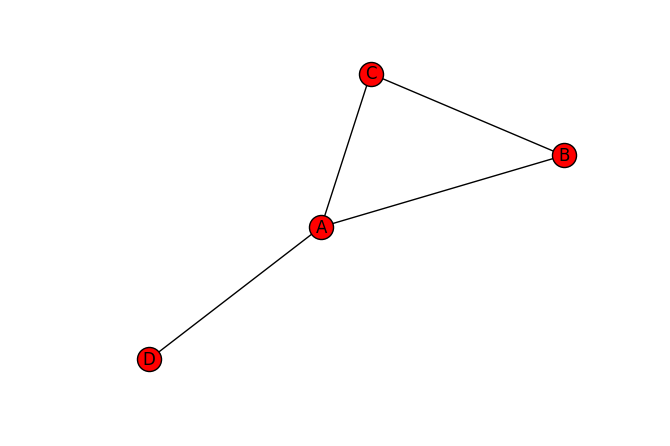

In [29]:
G=nx.Graph()
G.add_edge("A","B")
G.add_edge("A","C")
G.add_edge("B","C")
G.add_edge("A","D")
nx.draw(G,with_labels=True)

We have the following:
- Local clustering coefficients:
    - $A$ has 6 edge pairs and 2 oriented triangles: $c_A = \frac 1 3$
    - $B$ has 2 edge pairs and 2 oriented triangles: $c_B = 1$
    - $C$ has 2 edge pairs and 2 oriented triangles: $c_C = 1$
    - $D$ has 0 edge pairs and 0 oriented triangles: $c_D = 0$ by convention.
- Average local clustering: $C_l = \frac{1/3+1+1+0}{4}=\frac{7}{12}$.
- Global clustering coefficient: $C_g = \frac{2+2+2+0}{6+2+2+0} = \frac{3}{5}$
    - Notice that $C_g\neq C_l$.
    - One verifies that $C_g = \frac{1}{10}(6c_A+2c_B+2c_C+0c_D)$.
- Reference clustering: $C_r = \frac{4}{3\times 2} = \frac 2 3$

**Remark:** you may have noticed that the reference clustering is greater than the others, yet it is impossible to produce a graph with 4 nodes and 4 edges with a higher clustering. The short answer is that is is a border effect due to the small size of the graph. A deeper, slightly longer answer can be provided on demand.


## Question 1

Give a function that tells the local clustering coefficient $c_i$ of a node with id $i$ in DBLP. Try to make it as fast as possible.

**Hints:**
- The adjacency list you computed above will be quite useful.
- Your main focus should be the computation of the number of oriented triangles of $i$.
    - You can remark that $(j,k)$ is an oriented triangle of $i$ iff $j\in N(i)$, $k\in N(j)$ and $k\in N(i)$.
    - In particular, if you compute the set $N^2(i):=\cup_{j\in N(i)}N(j)$ with multiplicity (a given $k$ can be in the set multiple times if it is the neighbors of multiple $j$'s), you *just* have to count the number of elements of $N^2(i)$ that belongs to $N(i)$.
    - So you need to compute $N^2(i) = \{k \in N(j)\text{ s.t. }j\in N(i)\}$ (with multiplicity). Maybe it is time for you to start using the full power of list comprehension (see examples from [Basic Tools](#List-comprehension)).
    - Look at the **numpy** function **in1d**, it may be handy.
- Remind that a function call can slow down the execution. If it is a very small function, it may be faster to just rewrite it.
- To check your code, here are a few local clusterings:
    - "Marc-Olivier_Buob": 0.667
    - "Thomas_H._Clausen": 0.263
    - "Paul_Erdös": 0.039    
    - "Fabien_Mathieu": 0.159
    - "Jean-Louis_Rougier": 0.132

**Answer:**

## Question 2

Using list comprehensions, compute the list of $t_i$, then $C_l$, $C_g$, and $C_r$ for the DBLP graph.
- You can compute the $t_i$ in just one list comprehension (possibly nested).
- The computation of $t_i$ should take about 1-10 minutes if you have a clean code
    - Check your speed on small scales before launching the full computation.
    - Optimize your code!
    - you should save the result. Note that a list comprehension returns a Python list, which you may want to turn into a numpy array with *np.array()*.

**Answer:**

## Question 3

Discuss the values of $C_r$, $C_l$ and $C_g$. Can you give some explanation?

(in case you missed it, this question may be more important than the two previous ones)

**Answer:**

## Question 4 (bonus)

The DBLP dataset come from

http://konect.uni-koblenz.de/downloads/tsv/dblp_coauthor.tar.bz2

The format was not exactly the one used here, so it was converted with the following code.

Sadly, the intern that wrote the code didn't comment it. Can you reverse engineer the code and explain how it works?